# CVE Assigner Data

This notebook will pull all [JSON Data](https://nvd.nist.gov/vuln/data-feeds#JSON_FEED) from the NVD and performs some basic data analysis of CVEd data. 

## Getting Started

### Collecting Data

This cell pulls all JSON files from the NVD that we will be working with.

In [1]:
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2002..2021}.json.zip 
!unzip -o "*.zip" 

### Import Python Libraries

In [2]:
import calplot
import glob
import logging
import json
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import re
import uuid
import warnings
from datetime import datetime


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")


# All CVE Data

### Build Base DataFrame

This code builds a Panda dataframe from the JSON files we downloaded, removing all CVE's marked rejected.

In [3]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                assigner = entry['cve']['CVE_data_meta']['ASSIGNER']
            except KeyError:
                assigner = 'Missing_Data_JG'
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
    nvd = pd.DataFrame(row_accumulator)
    

nvd = nvd[(nvd['Published'] > '2021-01-01') & (nvd['Published'] < '2021-12-31')]
nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())
print ('CVEs from NVD:', nvd['CVE'].count())

CVEs from NVD: 16619


In [4]:
nvd_frequency = nvd['Assigner'].value_counts()
nvd_frequency = nvd_frequency.reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency[nvd_frequency.counts > 100].head(50)
nvd_frequency = nvd_frequency[~nvd_frequency.Assigner.str.contains('cve@mitre.org')]
nvd_frequency = nvd_frequency[nvd_frequency.counts > 100].head(20)
nvd_frequency 

,Assigner,counts
1,security-advisories@github.com,905
2,secure@microsoft.com,743
3,secalert_us@oracle.com,586
4,psirt@cisco.com,565
5,contact@wpscan.com,544
6,psirt@us.ibm.com,521
7,secalert@redhat.com,436
8,product-security@apple.com,390
9,security@android.com,361
10,psirt@adobe.com,358


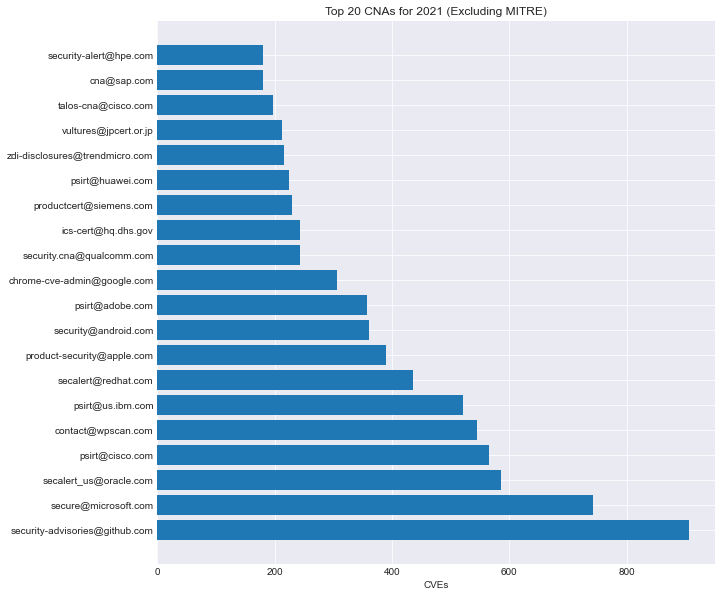

In [5]:
plt.figure(figsize=(10,10))
plt.style.use('seaborn-darkgrid')
plt.barh("Assigner", "counts", data = nvd_frequency)
plt.xlabel("CVEs") 
plt.ylabel("") 
plt.title("Top 20 CNAs for 2021 (Excluding MITRE)")
plt.savefig('2021topassinger.jpg', dpi=300, bbox_inches='tight')
